In [16]:
import torch
import random
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as pl
import torch.nn.functional as F
import torchvision.models as models

In [17]:
from PIL import Image
from pathlib import Path
from torchvision import transforms
from Models.VGG19_model import VGG19

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [19]:
original_vgg19_model = models.vgg19(weights = 'VGG19_Weights.DEFAULT')
vgg = VGG19(original_vgg19_model)
vgg.load_state_dict(torch.load('../assets/vgg19_transfer.pth', map_location = device))
vgg.eval()

VGG19(
  (original_vgg19_model): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)

In [20]:
def choose_random_image():
  image_path = random.choice(list(Path('../assets/Dataset').glob('*/*/*.jpg')))
  image_class = image_path.parent.stem

  image = Image.open(image_path)
  image = image.convert('RGB')
  image = image.resize((224, 224))

  return image, image_class

def draw(image, label = ''):
  pl.figure(figsize = (6, 6))
  if label != '': pl.title(f'{label}')
  pl.imshow(image)
  pl.axis('off')
  pl.show()

image_transform = transforms.Compose([
  transforms.Resize((224, 224)),
  transforms.ToTensor(),
  transforms.Normalize(mean = [0.1855, 0.1855, 0.1855], std = [0.2003, 0.2003, 0.2004])
])

In [21]:
def prepare_image(path):
  image = Image.open(path)
  image = image.convert('RGB')
  image = image.resize((224, 224))

  pl.figure(figsize = (6, 6))
  pl.imshow(image)
  pl.axis('off')
  pl.show()

  image = image_transform(image)
  image = image.unsqueeze(0)
  image = image.to(device)

  return image

In [22]:
class DeVGG19(nn.Module):
  def __init__(self, vgg19):
    super(DeVGG19, self).__init__()

    self.base_model: VGG19 = vgg19
    self.batches: list = []
    self.sizes: list = []

    self.deconvolution = nn.Sequential(
      nn.MaxUnpool2d(kernel_size = 2, stride = 2),                                  # 36

      nn.ReLU(inplace = True),                                                      # 35
      nn.ConvTranspose2d(512, 512, kernel_size = 3, stride = 1, padding = 1),       # 34
      nn.ReLU(inplace = True),                                                      # 33
      nn.ConvTranspose2d(512, 512, kernel_size = 3, stride = 1, padding = 1),       # 32
      nn.ReLU(inplace = True),                                                      # 31
      nn.ConvTranspose2d(512, 512, kernel_size = 3, stride = 1, padding = 1),       # 30
      nn.ReLU(inplace = True),                                                      # 29
      nn.ConvTranspose2d(512, 512, kernel_size = 3, stride = 1, padding = 1),       # 28
      
      nn.MaxUnpool2d(kernel_size = 2, stride = 2),                                  # 27

      nn.ReLU(inplace = True),                                                      # 26
      nn.ConvTranspose2d(512, 512, kernel_size = 3, stride = 1, padding = 1),       # 25
      nn.ReLU(inplace = True),                                                      # 24
      nn.ConvTranspose2d(512, 512, kernel_size = 3, stride = 1, padding = 1),       # 23
      nn.ReLU(inplace = True),                                                      # 22
      nn.ConvTranspose2d(512, 512, kernel_size = 3, stride = 1, padding = 1),       # 21
      nn.ReLU(inplace = True),                                                      # 20
      nn.ConvTranspose2d(512, 256, kernel_size = 3, stride = 1, padding = 1),       # 19

      nn.MaxUnpool2d(kernel_size = 2, stride = 2),                                  # 18

      nn.ReLU(inplace = True),                                                      # 17
      nn.ConvTranspose2d(256, 256, kernel_size = 3, stride = 1, padding = 1),       # 16
      nn.ReLU(inplace = True),                                                      # 15
      nn.ConvTranspose2d(256, 256, kernel_size = 3, stride = 1, padding = 1),       # 14
      nn.ReLU(inplace = True),                                                      # 13
      nn.ConvTranspose2d(256, 256, kernel_size = 3, stride = 1, padding = 1),       # 12
      nn.ReLU(inplace = True),                                                      # 11
      nn.ConvTranspose2d(256, 128, kernel_size = 3, stride = 1, padding = 1),       # 10
      
      nn.MaxUnpool2d(kernel_size = 2, stride = 2),                                  # 9
      
      nn.ReLU(inplace = True),                                                      # 8
      nn.ConvTranspose2d(128, 128, kernel_size = 3, stride = 1, padding = 1),       # 7
      nn.ReLU(inplace = True),                                                      # 6
      nn.ConvTranspose2d(128, 64, kernel_size = 3, stride = 1, padding = 1),        # 5
      
      nn.MaxUnpool2d(kernel_size = 2, stride = 2),                                  # 4

      nn.ReLU(inplace = True),                                                      # 3
      nn.ConvTranspose2d(64, 64, kernel_size = 3, stride = 1, padding = 1),         # 2
      nn.ReLU(inplace = True),                                                      # 1
      nn.ConvTranspose2d(64, 3, kernel_size = 3, stride = 1, padding = 1),          # 0
    )
  
  def forward(self, batch: torch.Tensor):
    # Conv forward
    for i, layer in enumerate(self.base_model.features):
      if isinstance(layer, nn.MaxPool2d):
        self.sizes.append(batch.size())
        batch, indices = layer(batch)
        self.base_model.switch_indices[i] = indices
      else:
        batch = layer(batch)

    # DeConv forward
    size_index: int = 4
    for i, layer in enumerate(self.deconvolution):
      if isinstance(layer, nn.MaxUnpool2d):
        batch = layer(batch, self.base_model.switch_indices[36 - i], output_size = self.sizes[size_index])
        size_index -= 1
      else:
        batch = layer(batch)
        
      self.batches.append(batch)
    return batch

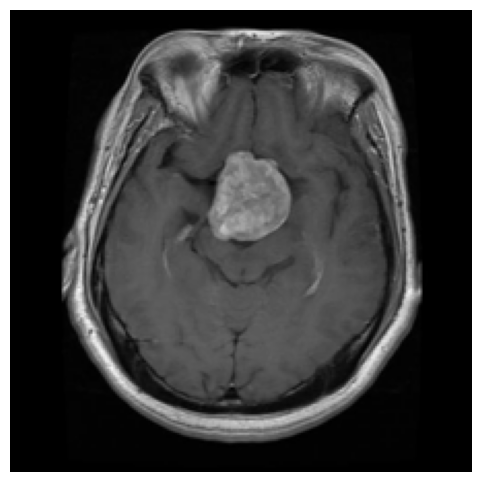

In [23]:
image = prepare_image('test_pituitary.jpg')

In [24]:
deconv_net = DeVGG19(vgg)
deconv_net.to(device)
deconv_net.eval()

reconstructed_image = deconv_net(image).detach().numpy()[0, 2, :]

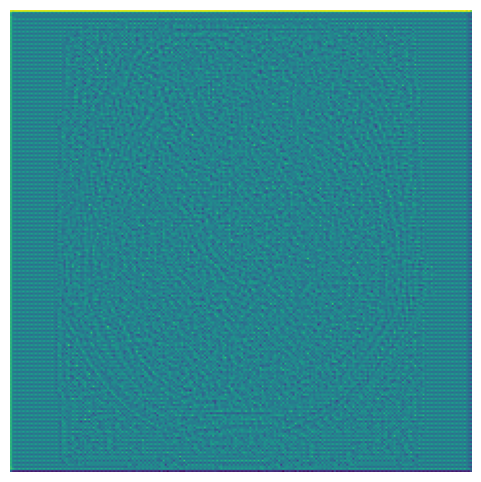

In [25]:
draw(reconstructed_image)

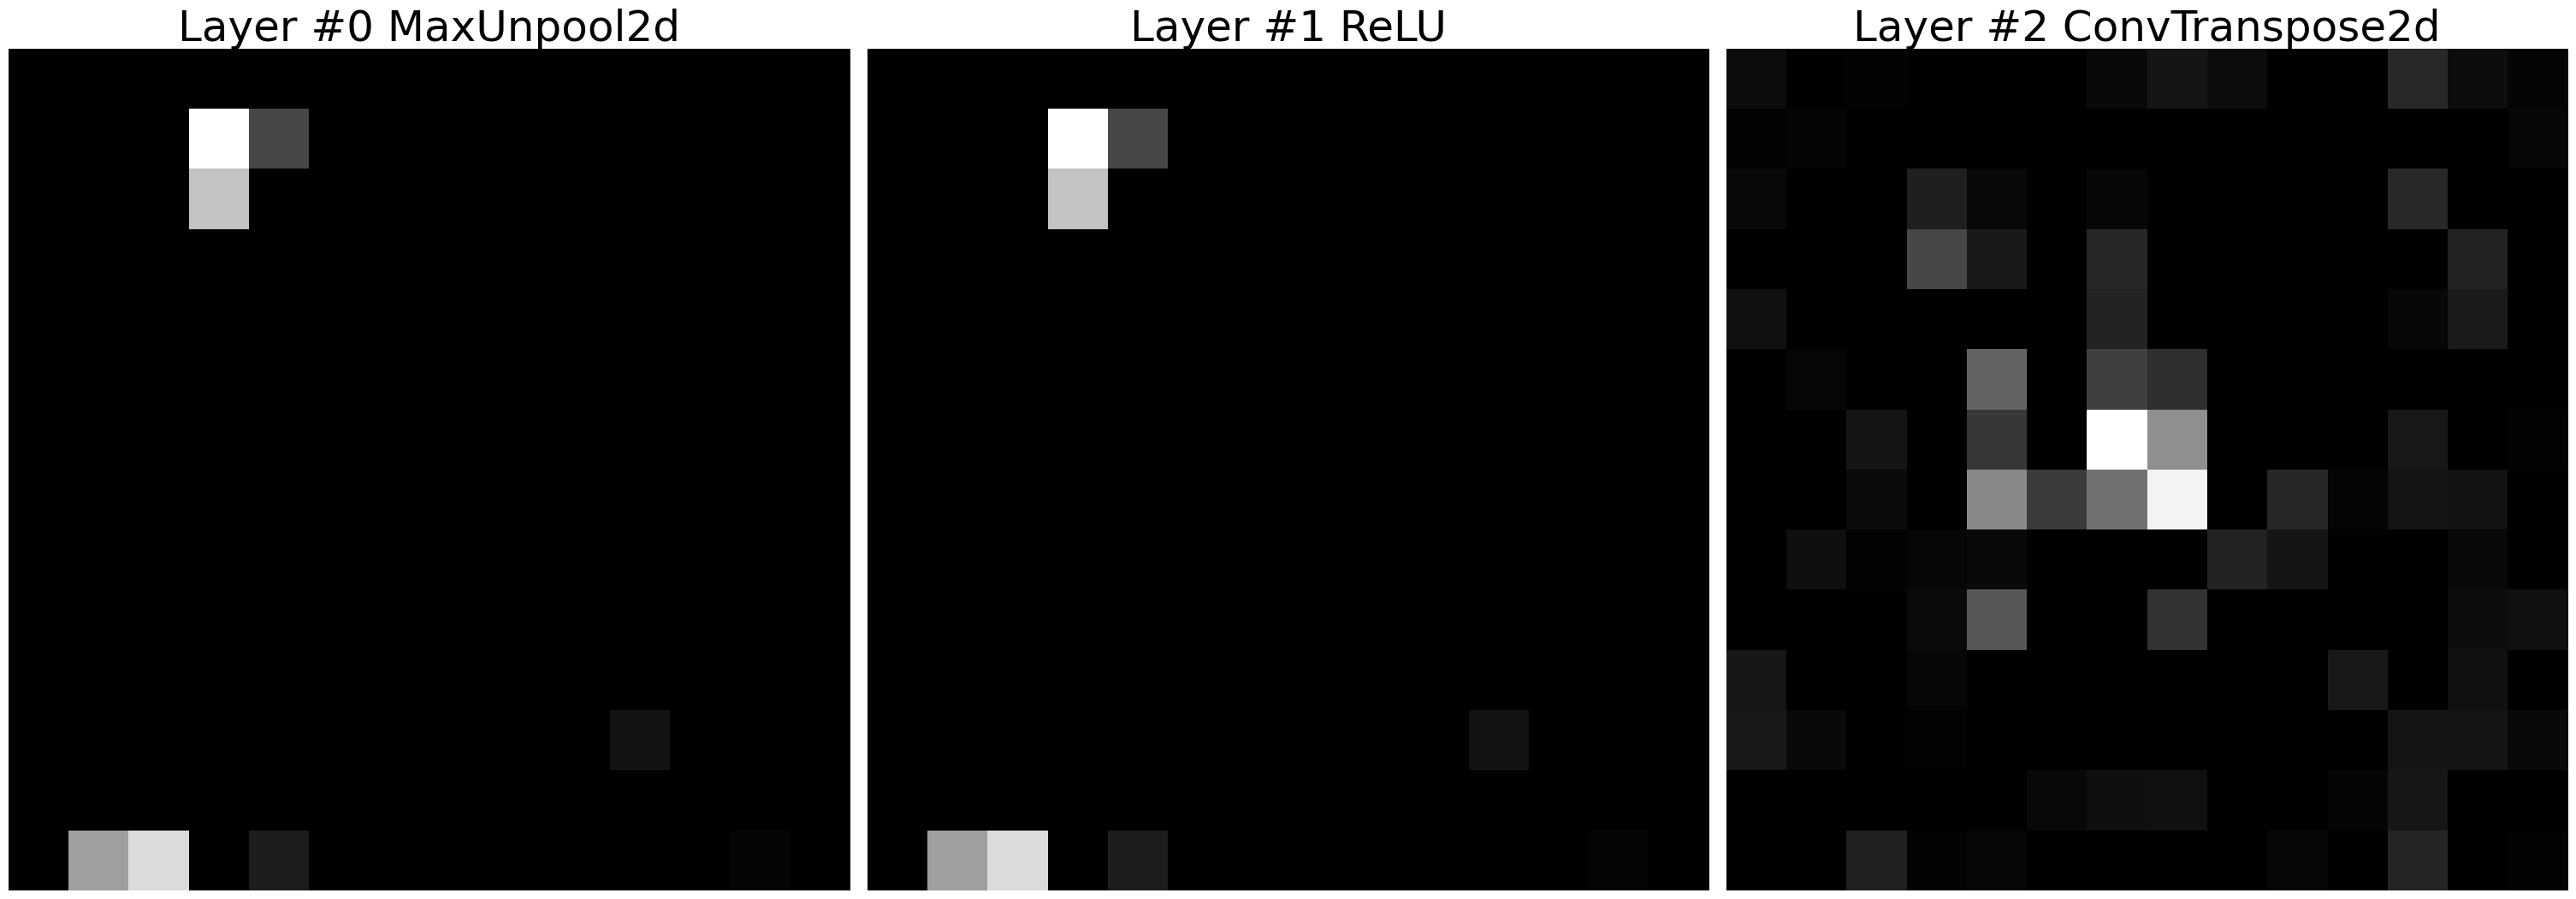

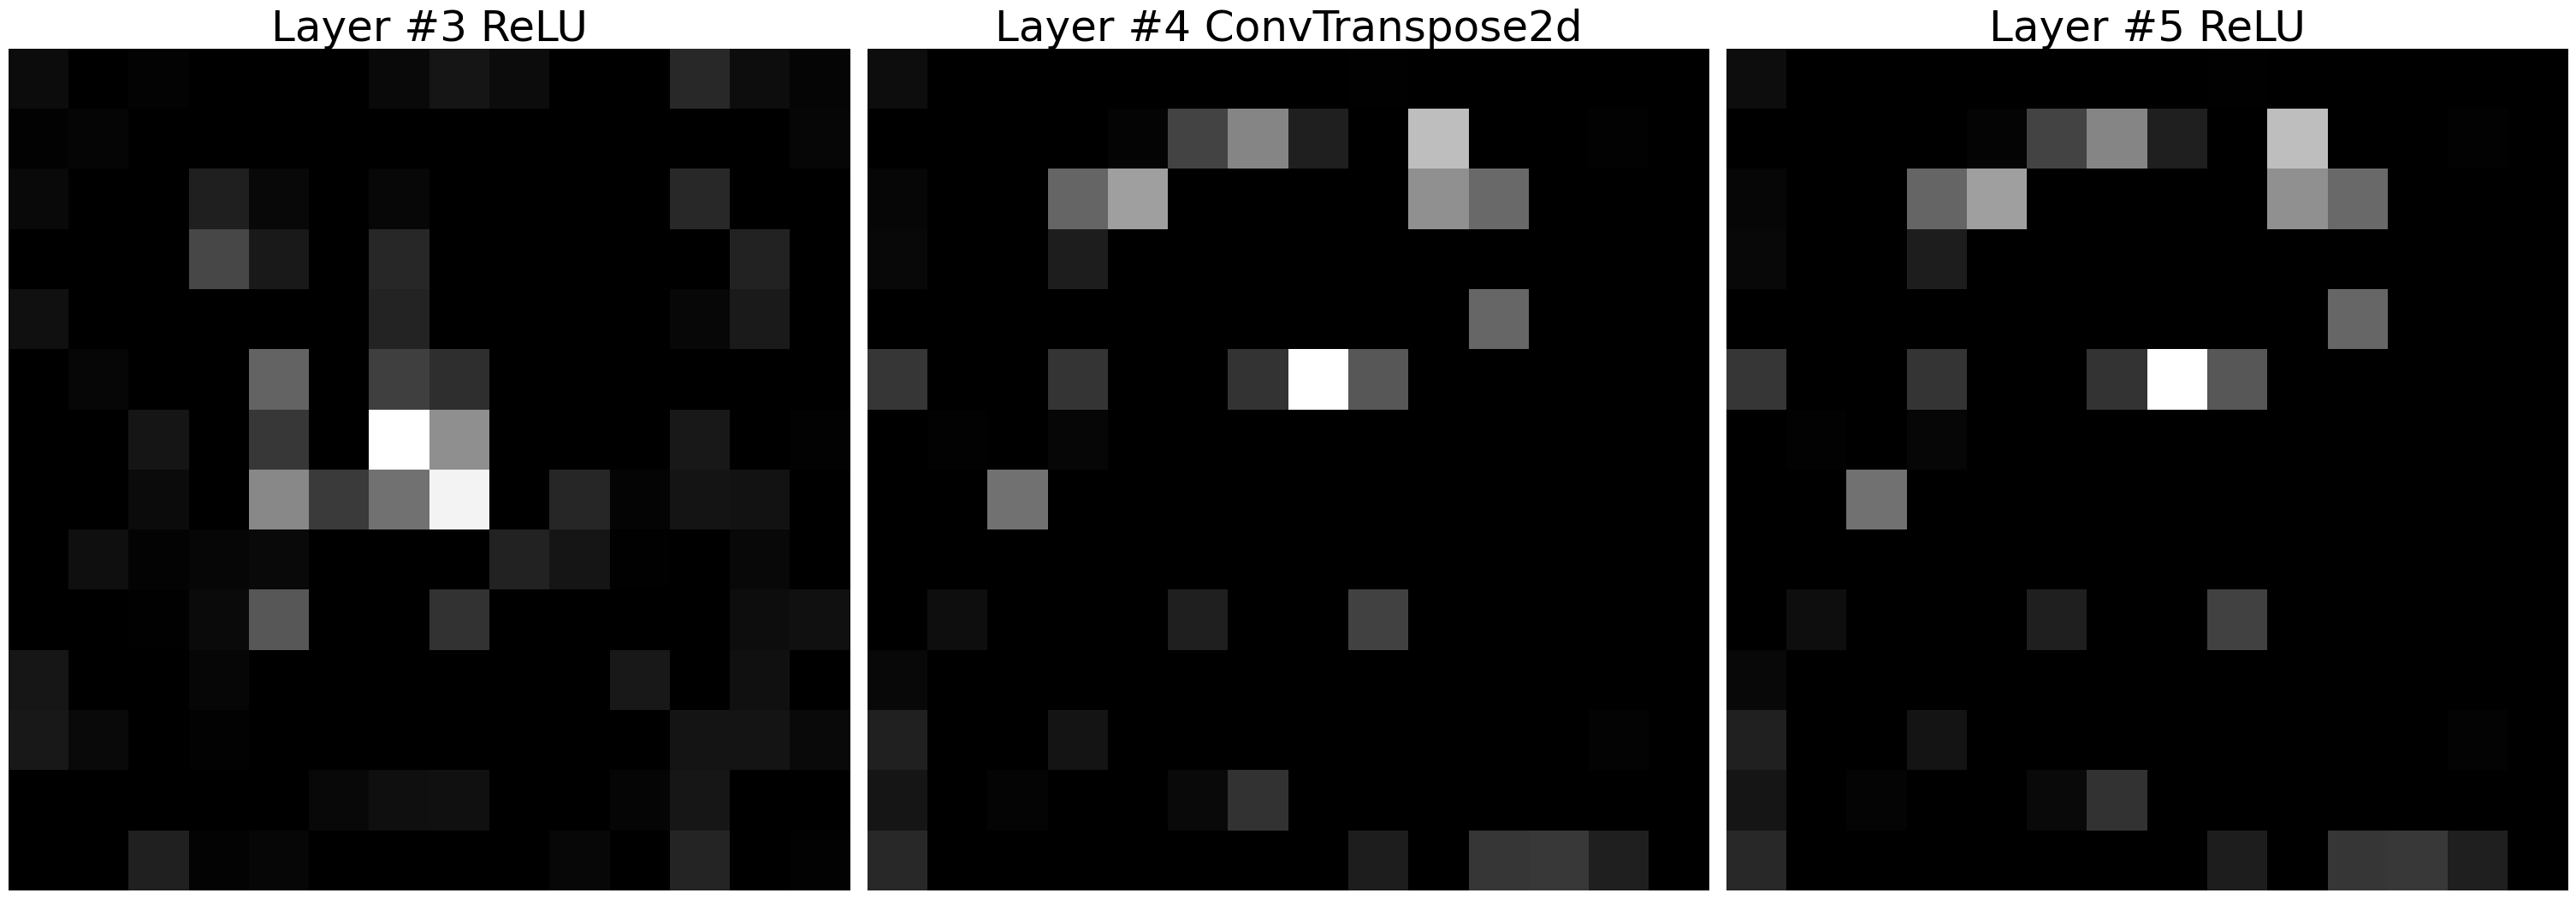

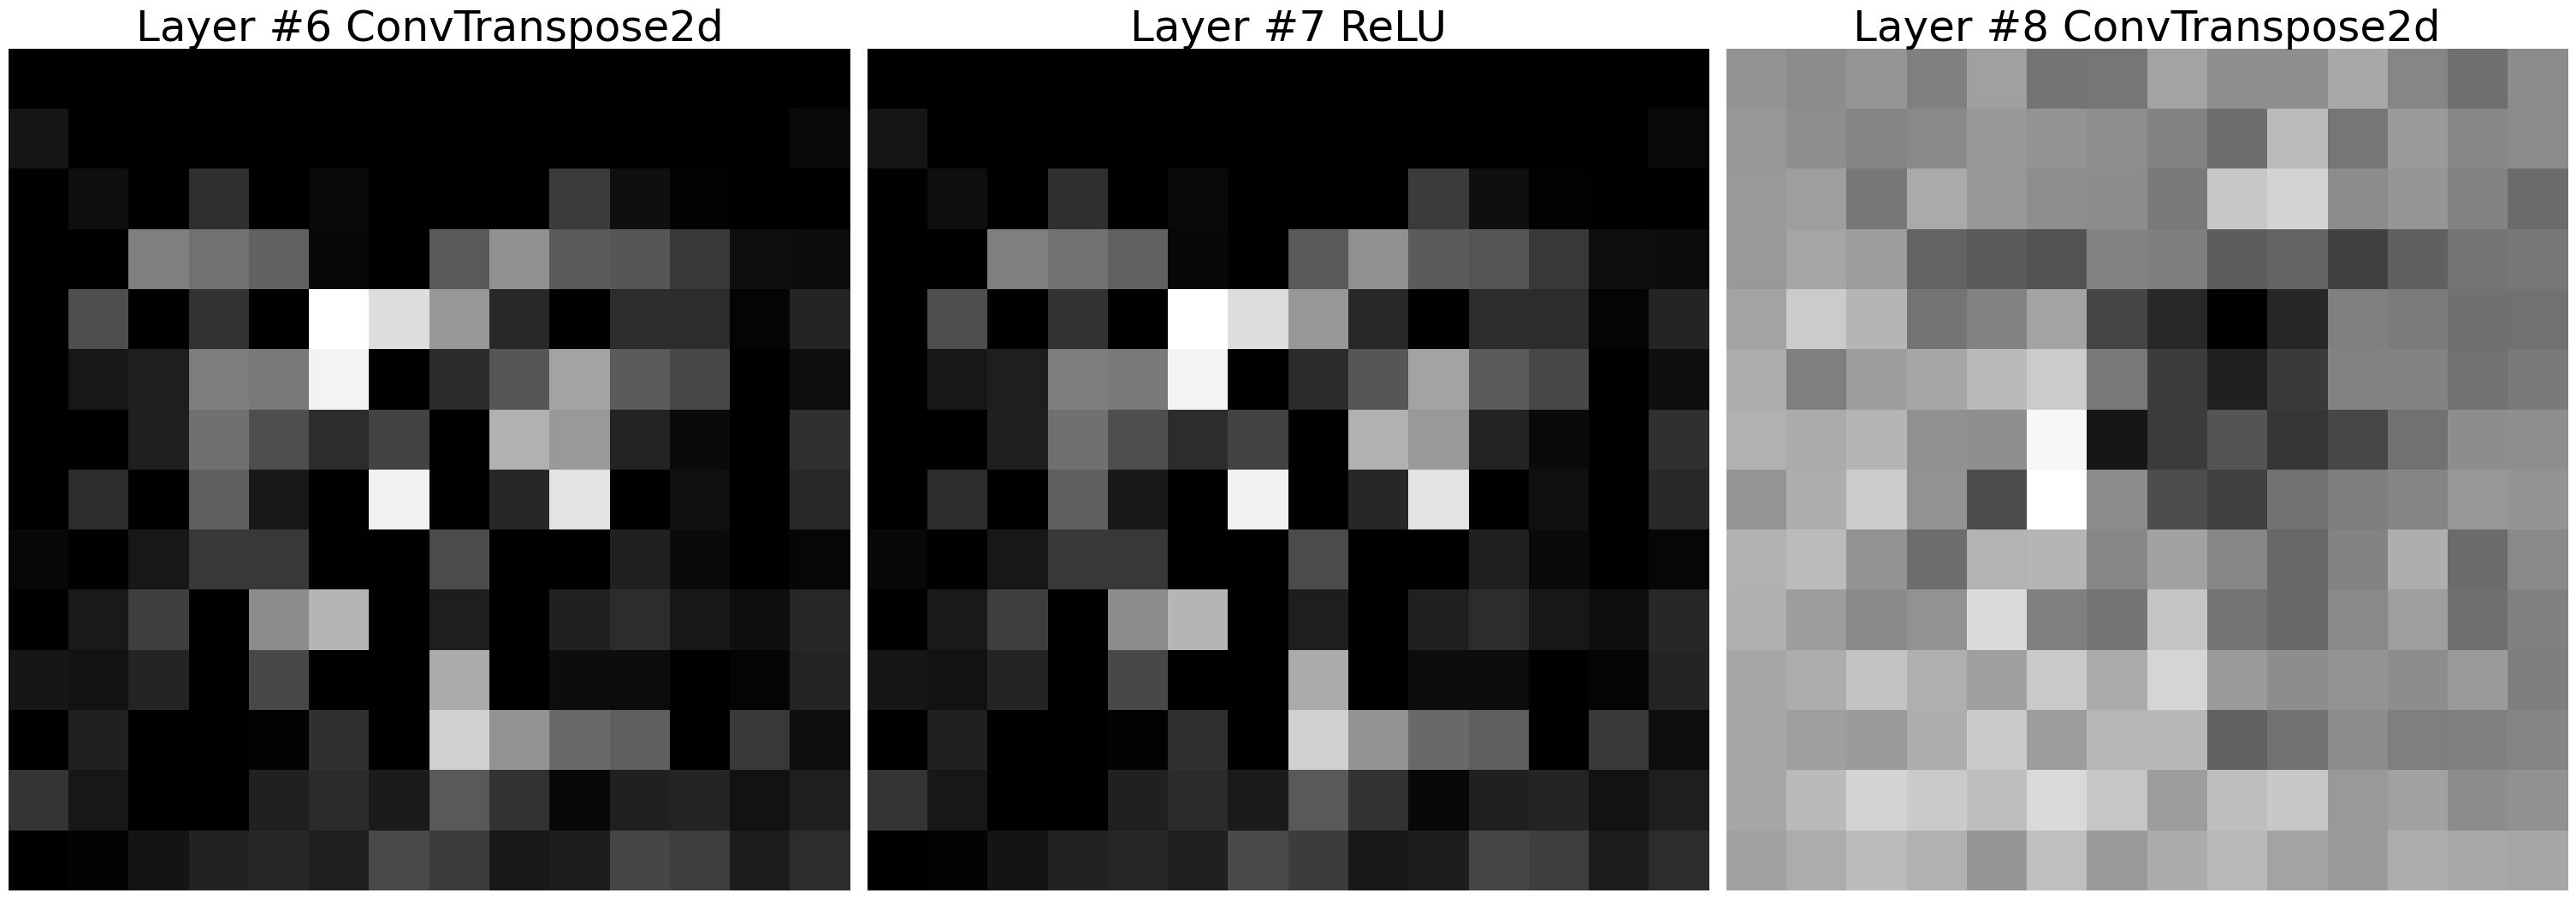

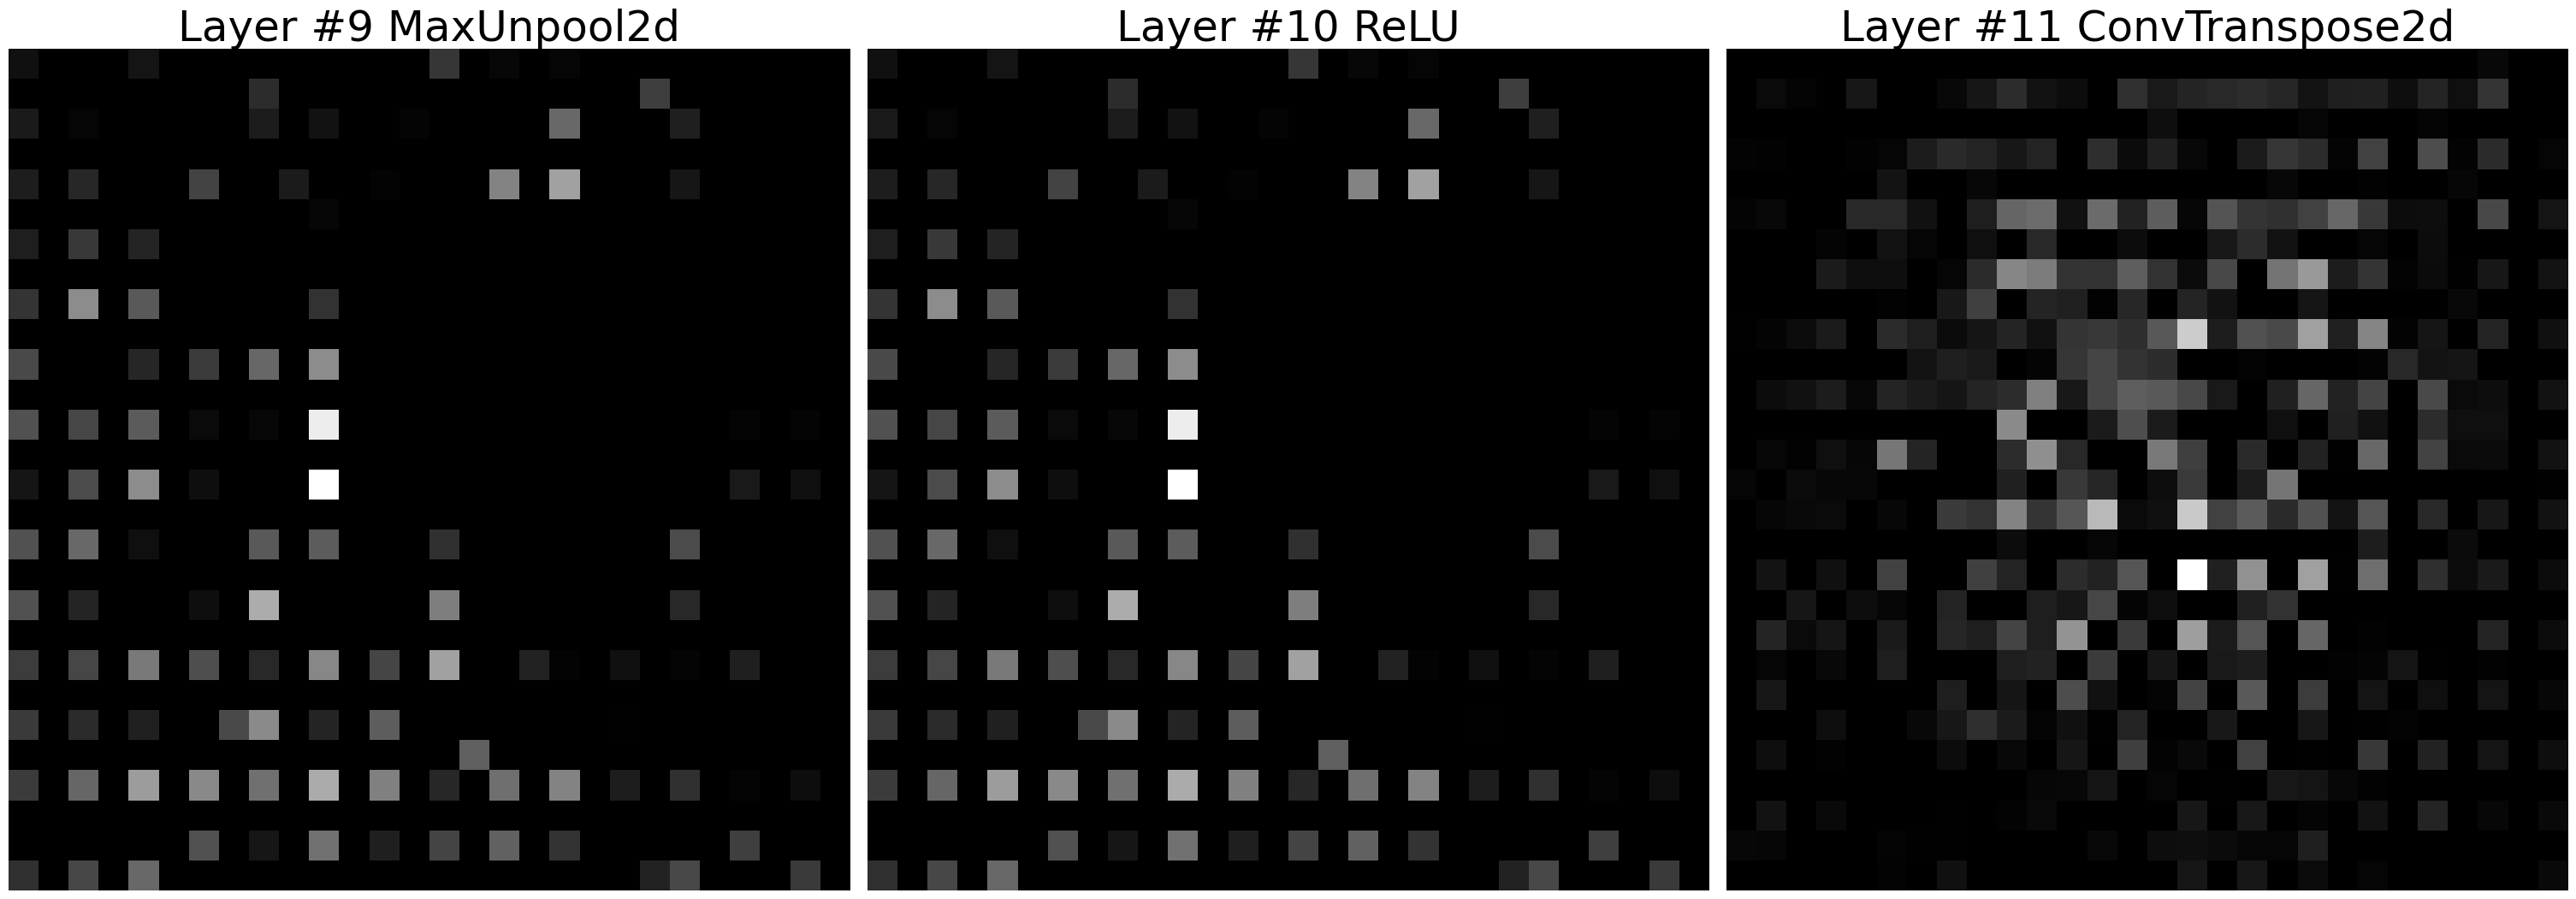

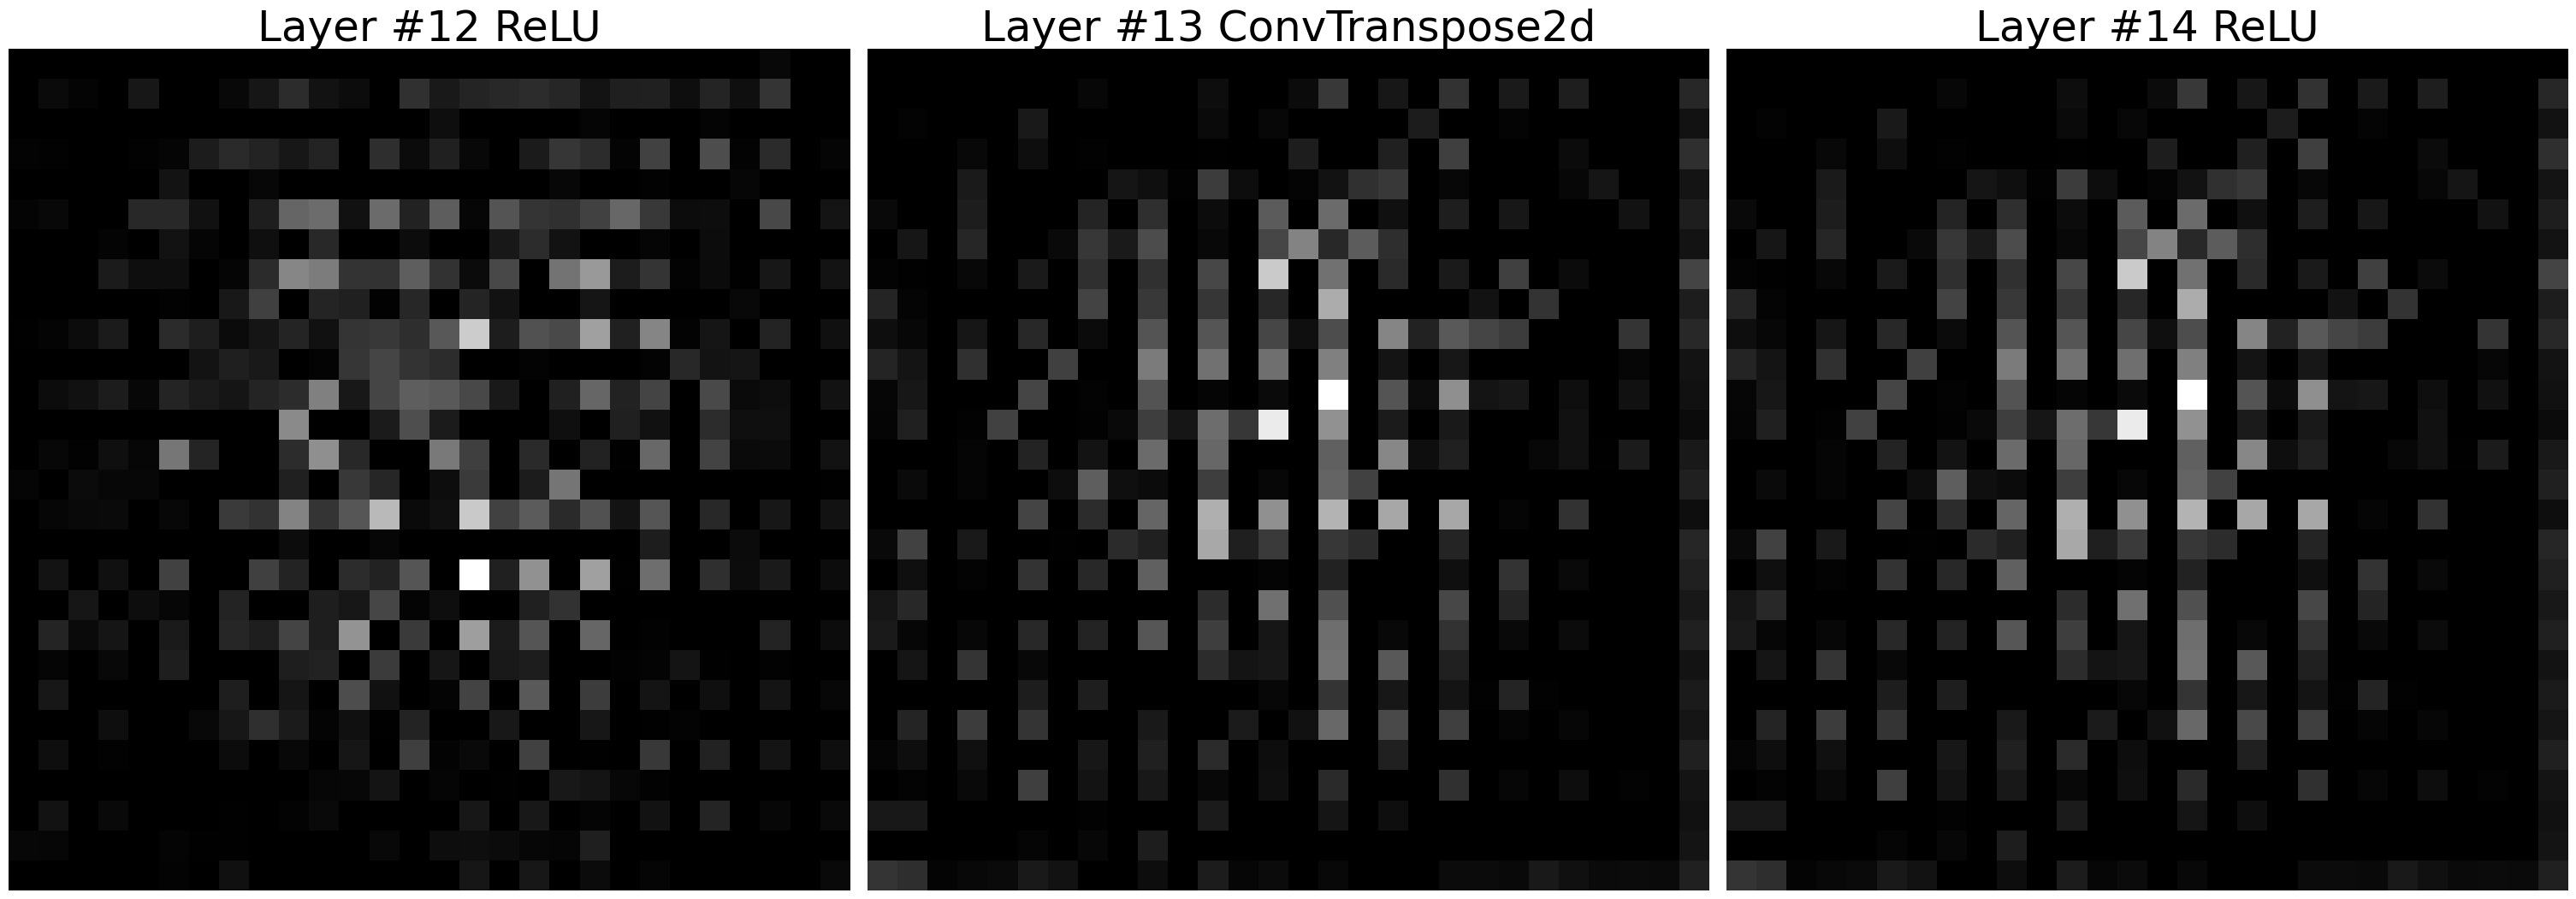

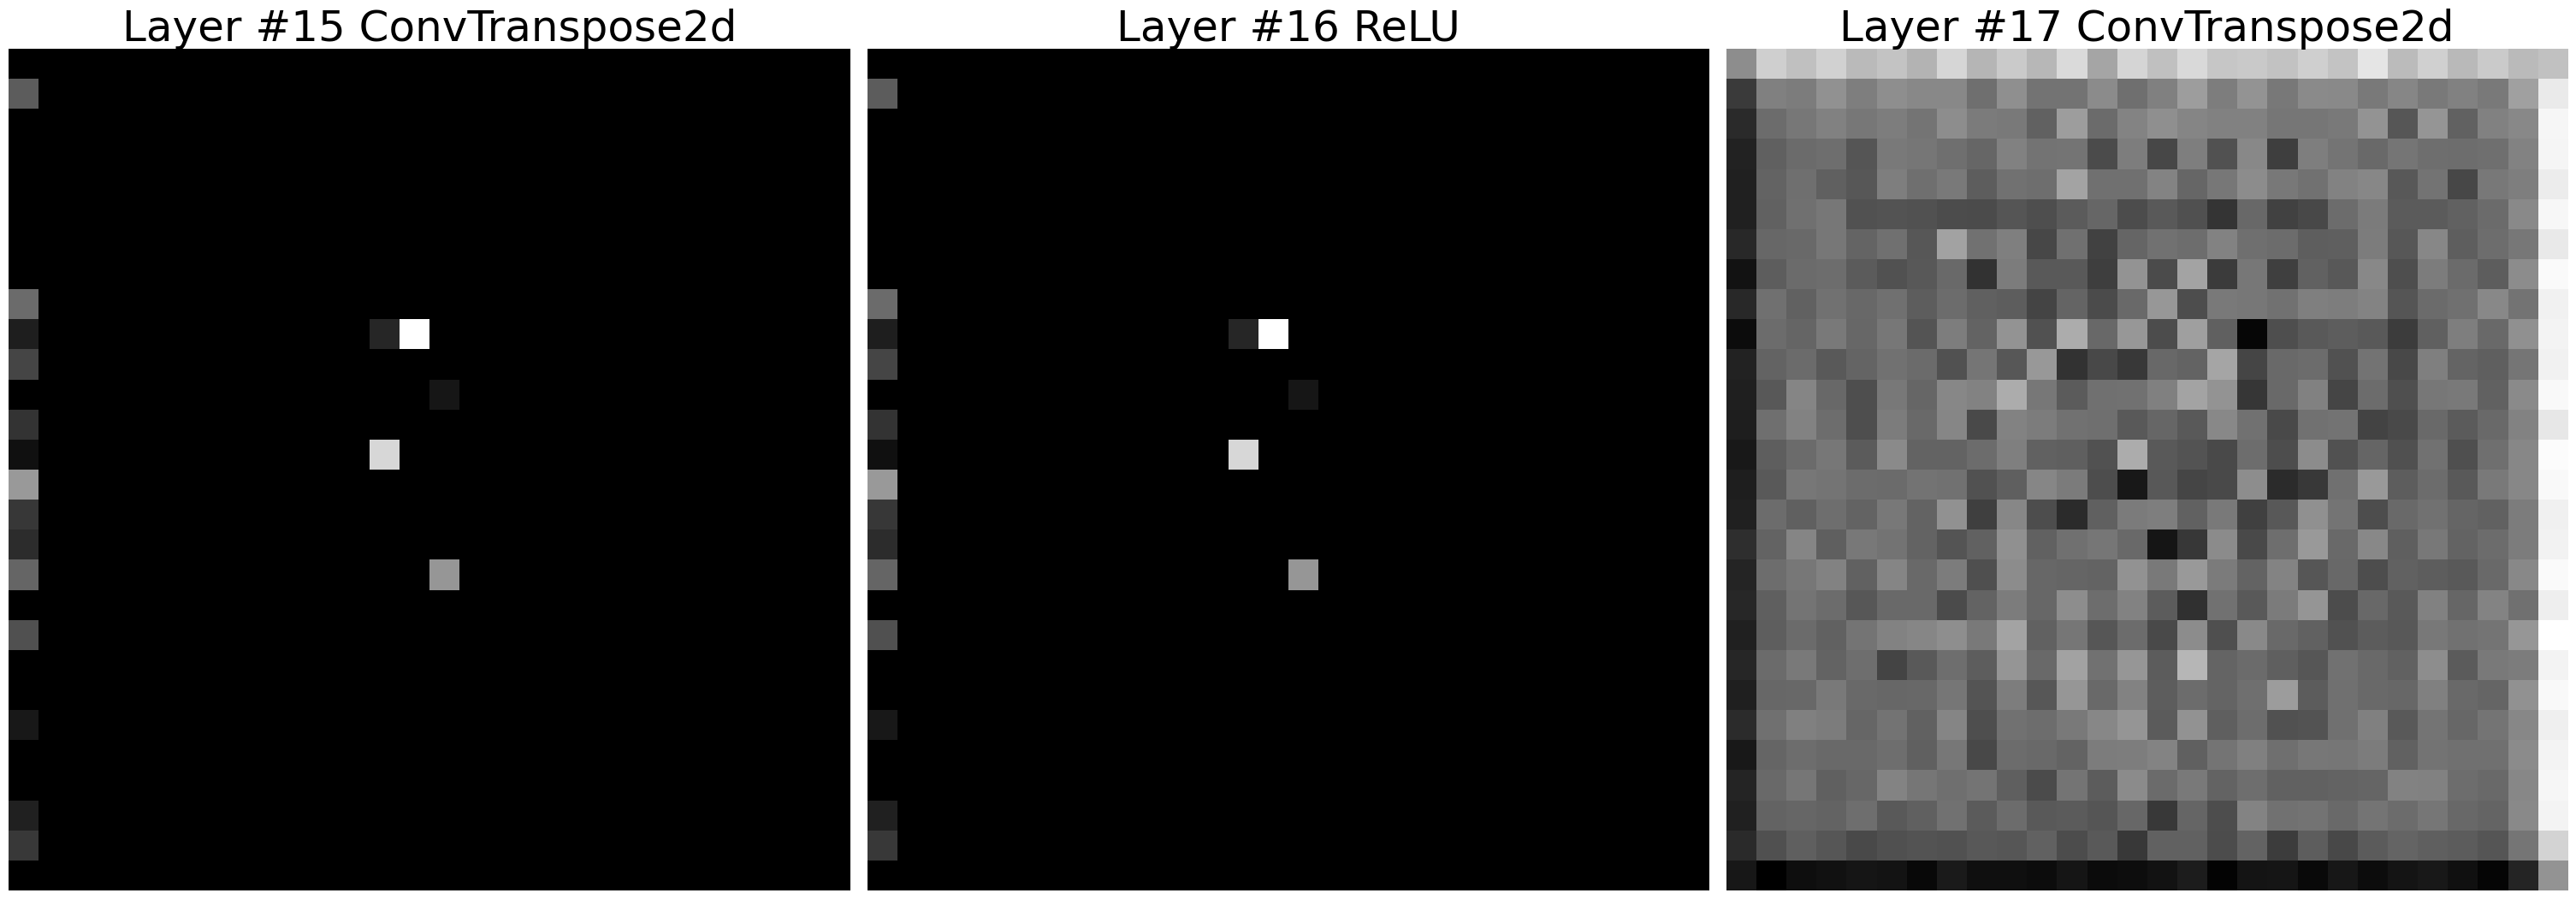

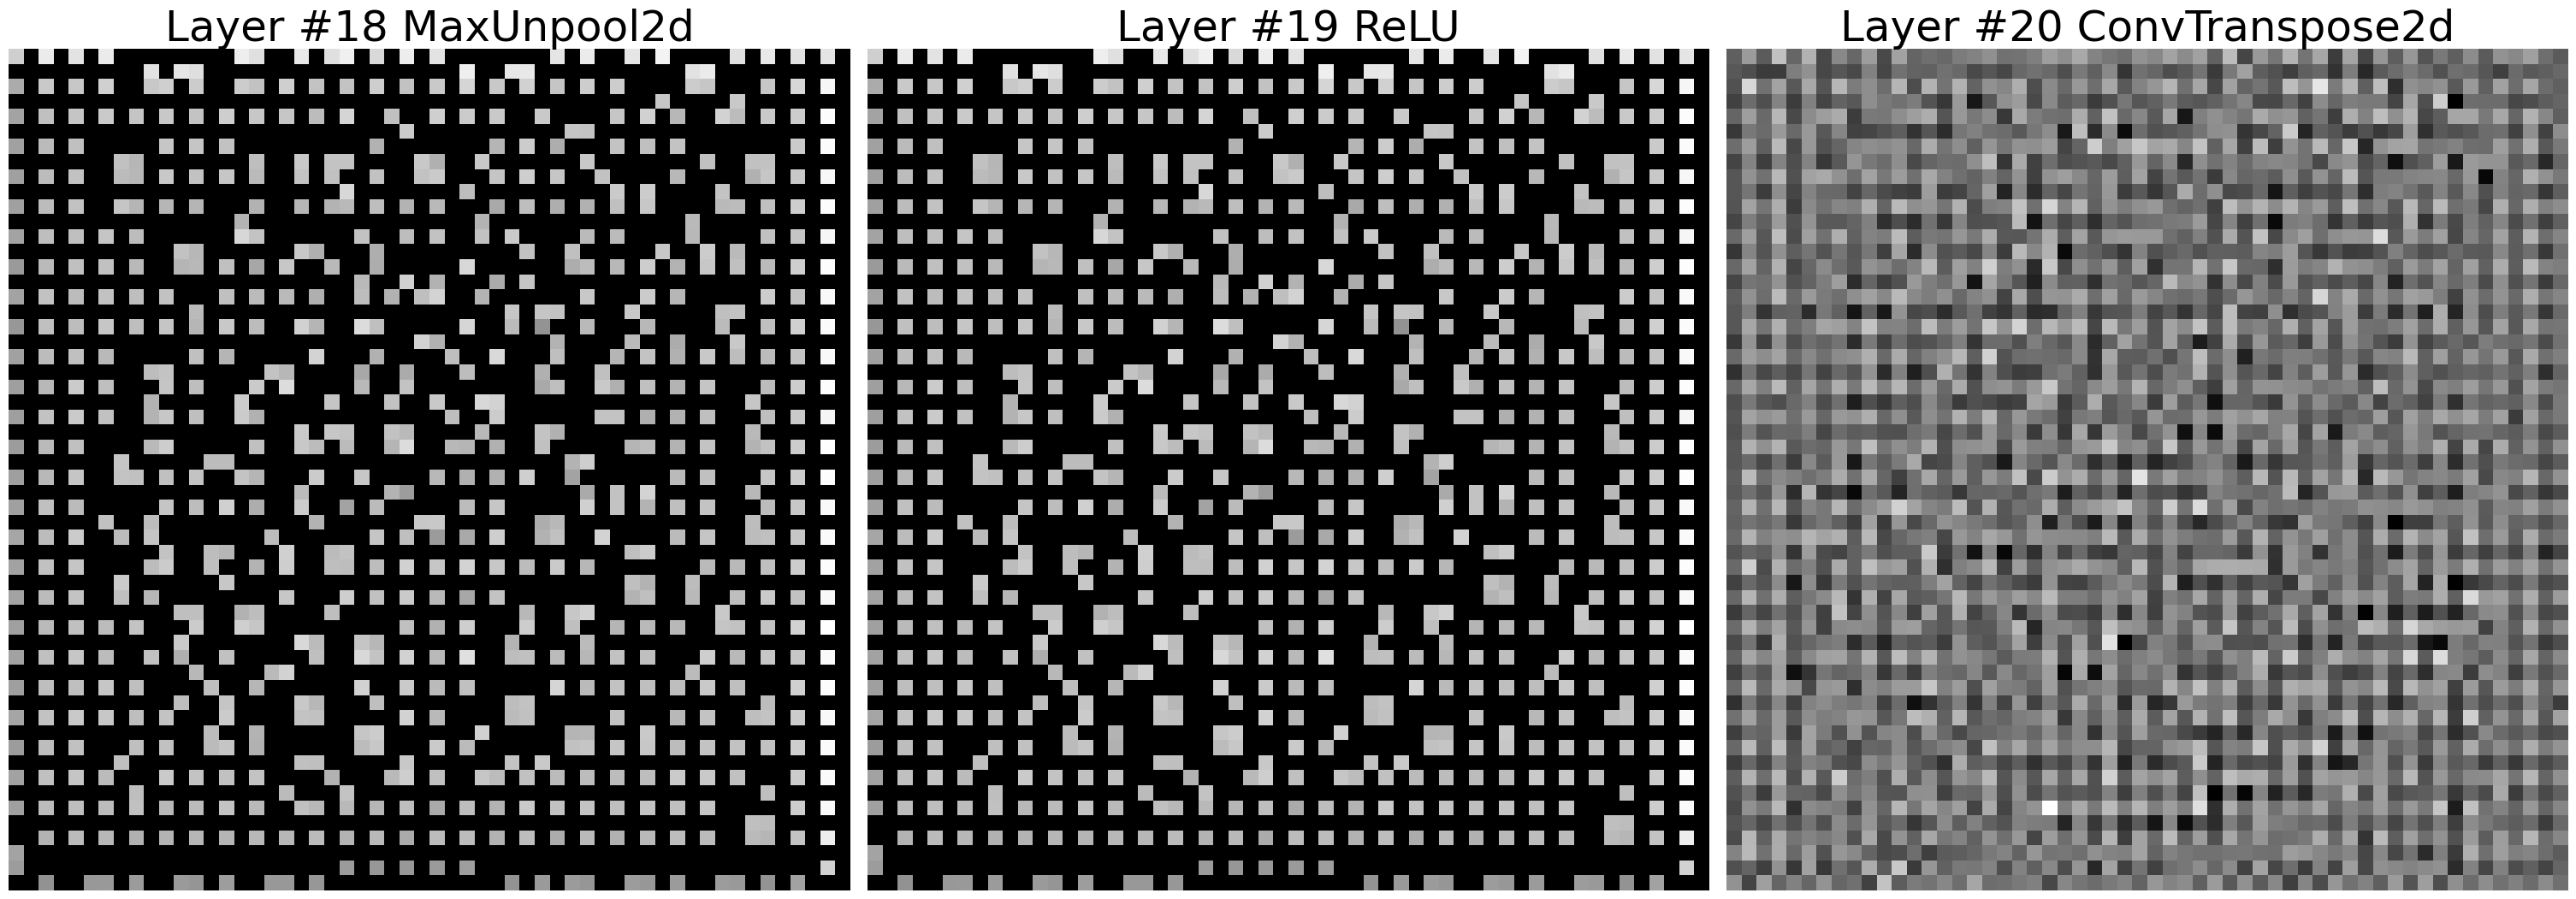

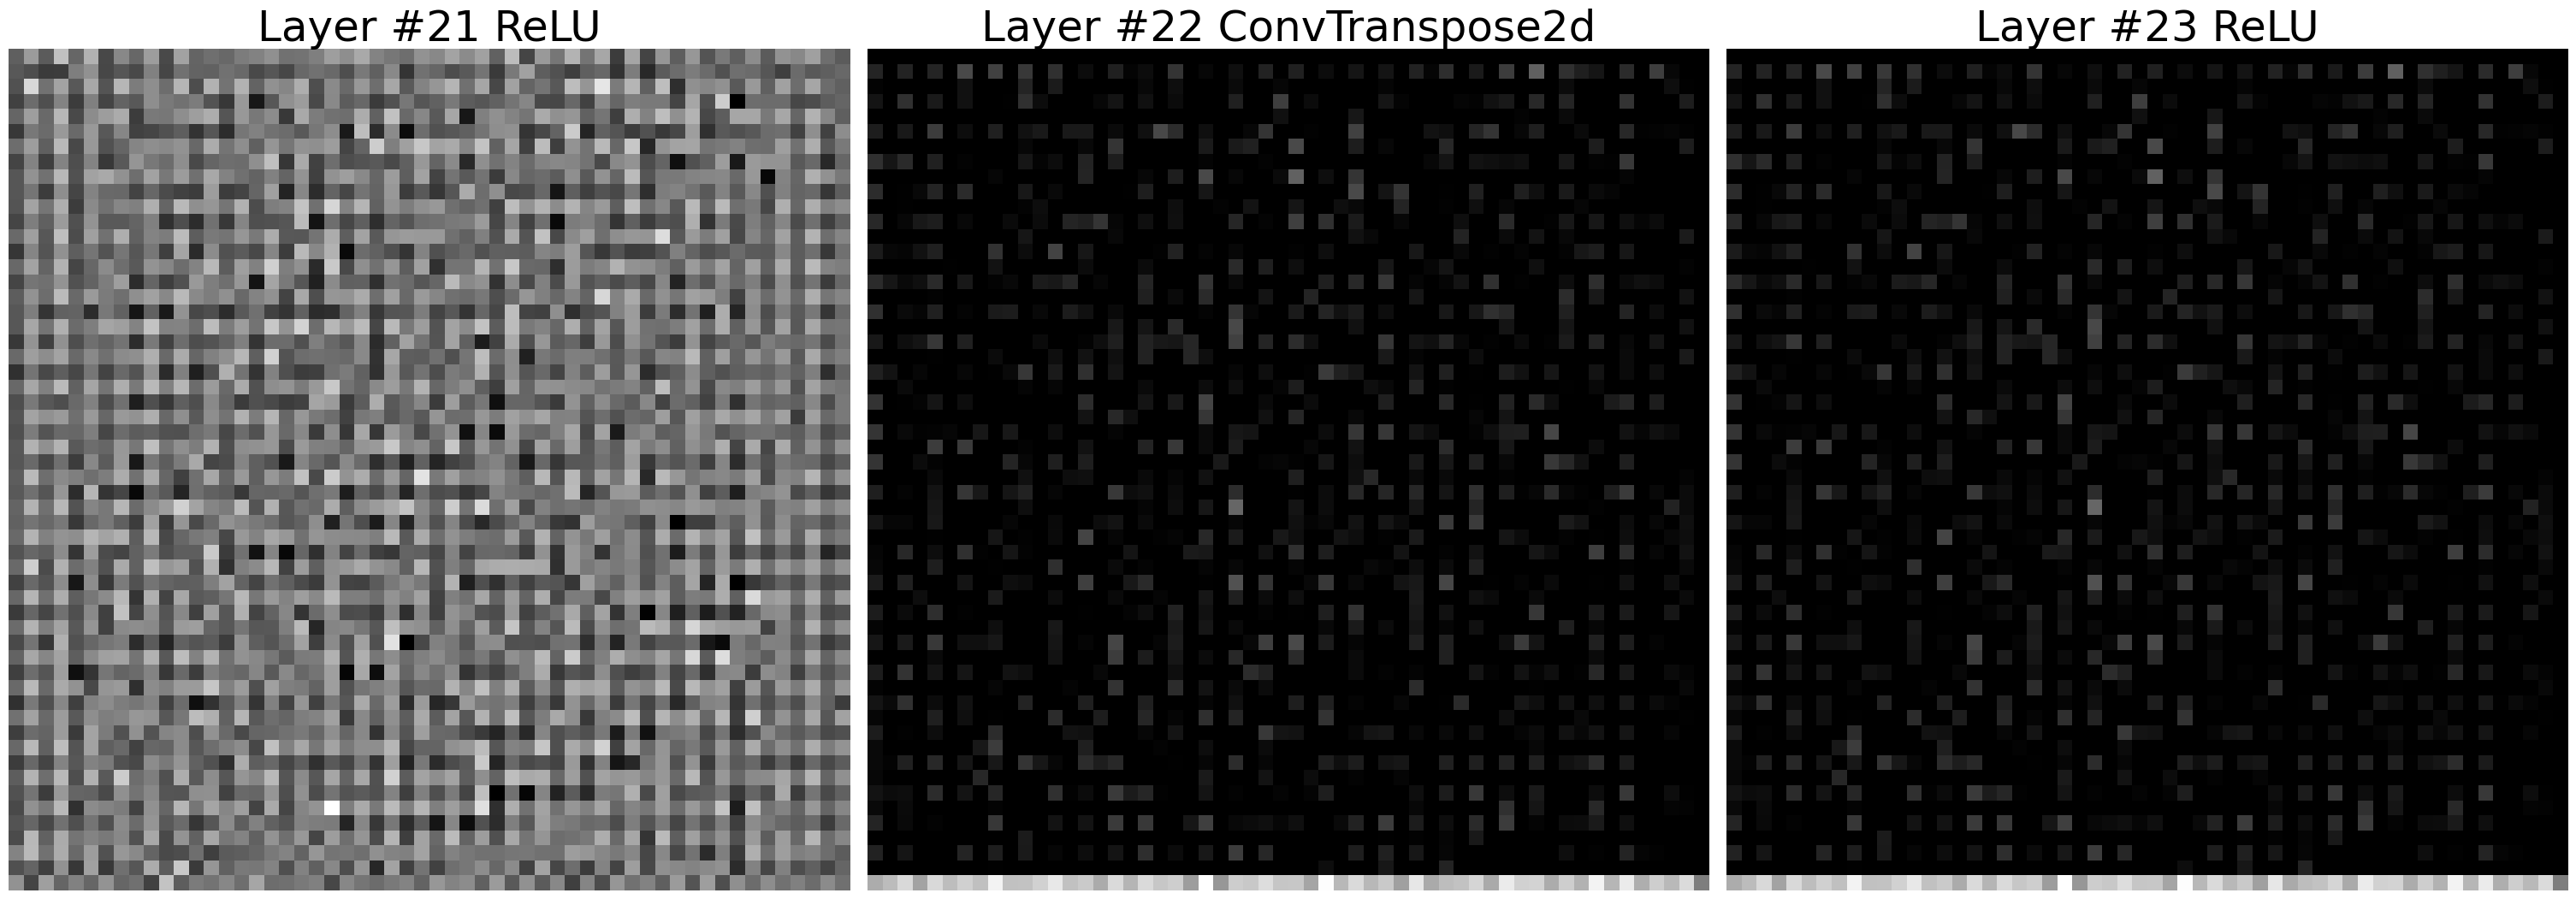

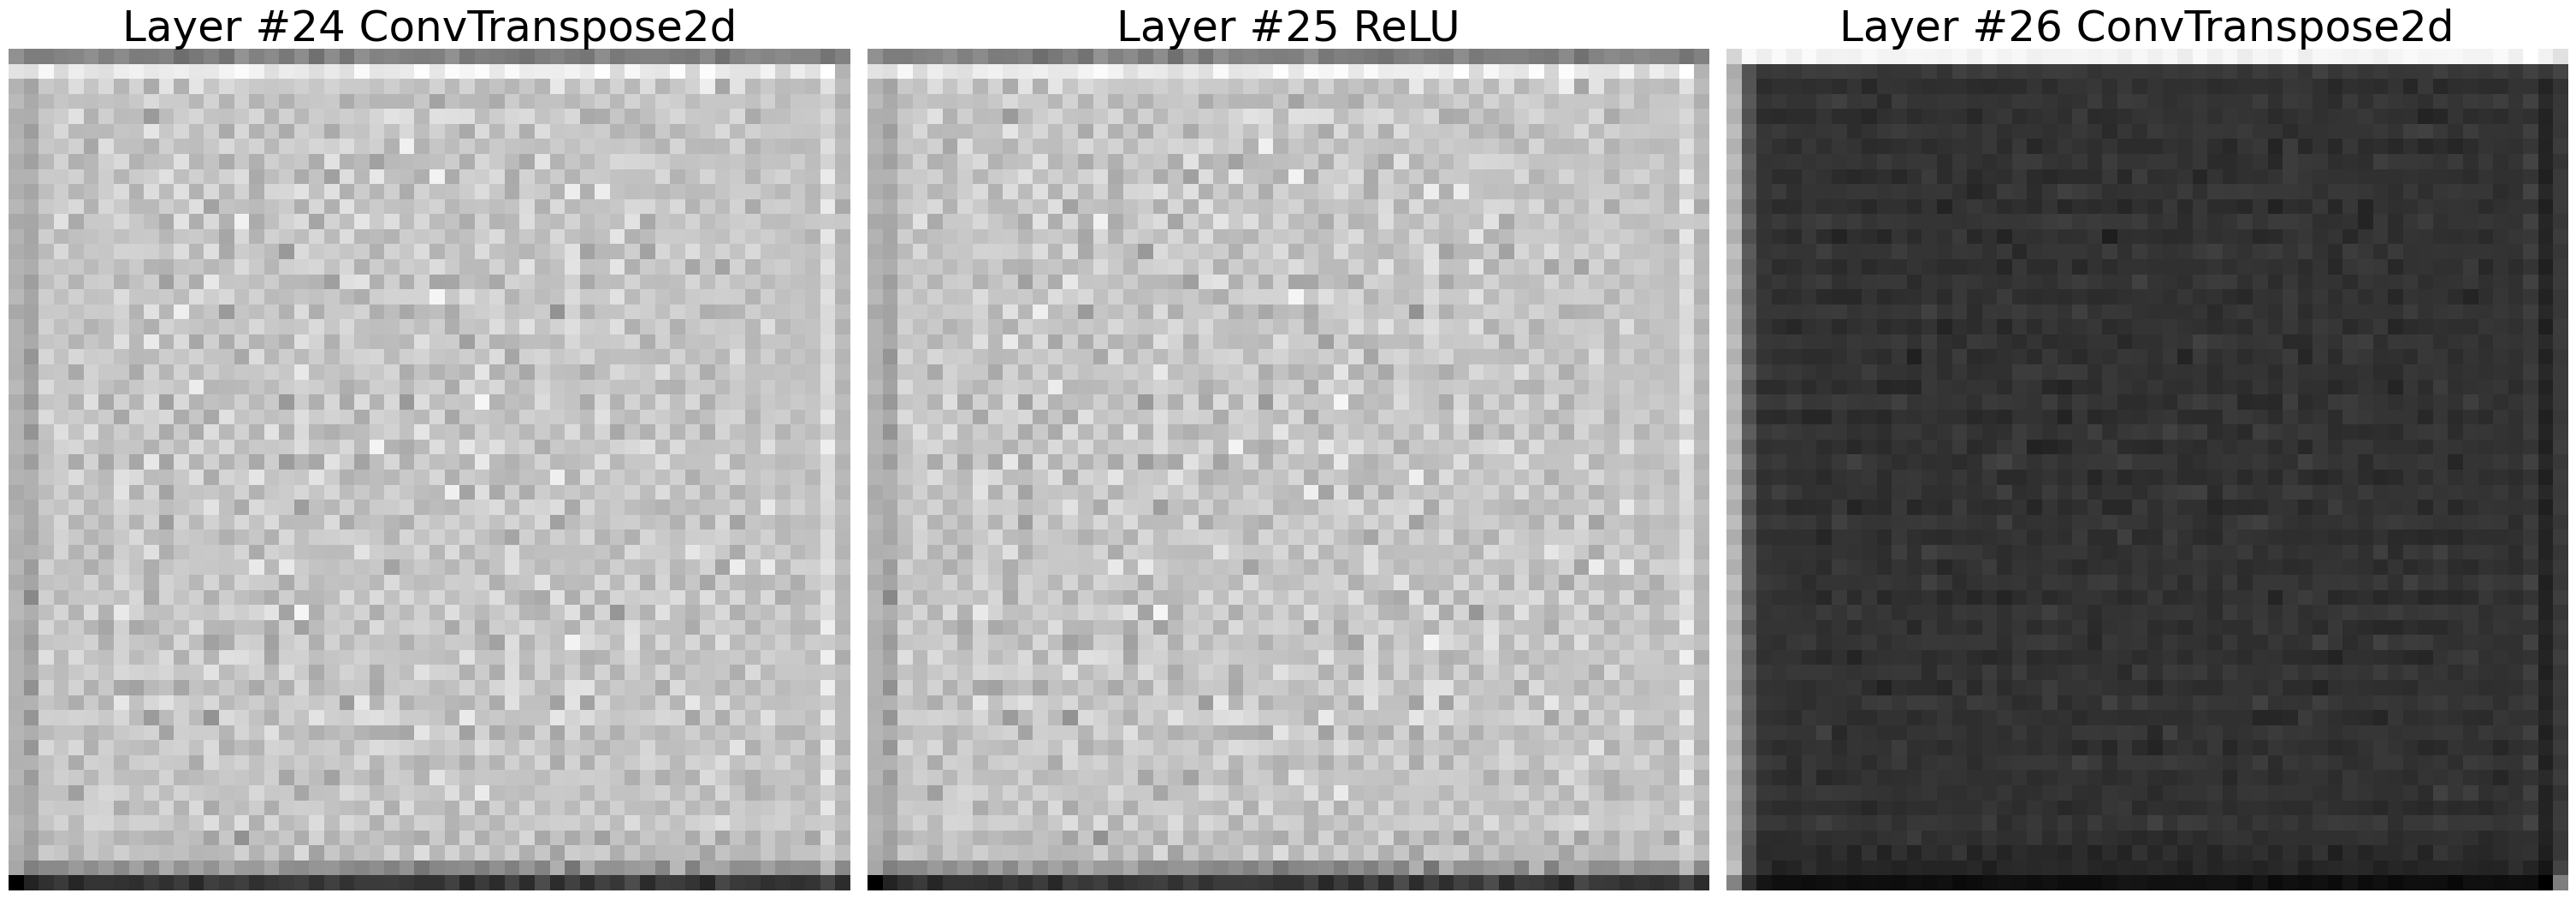

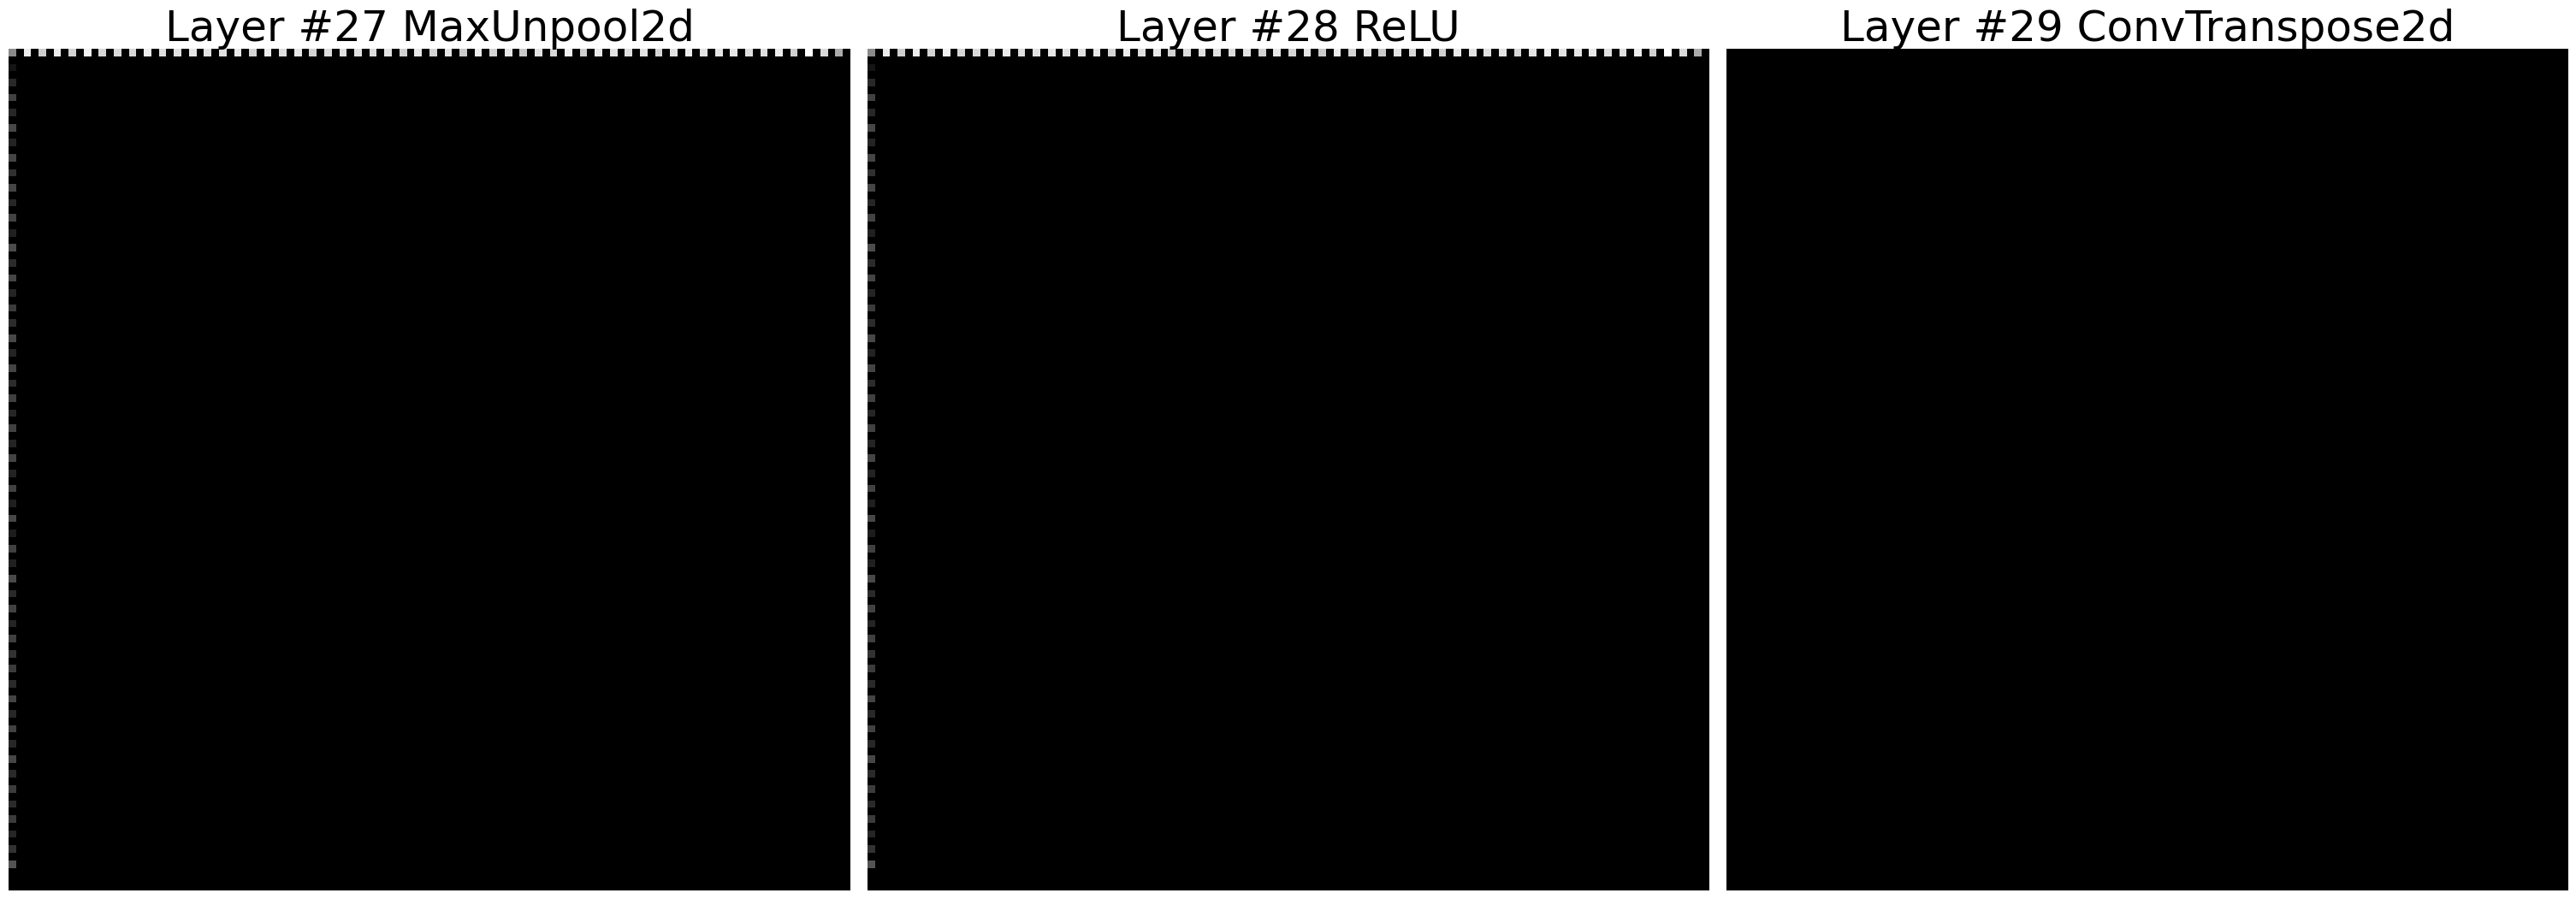

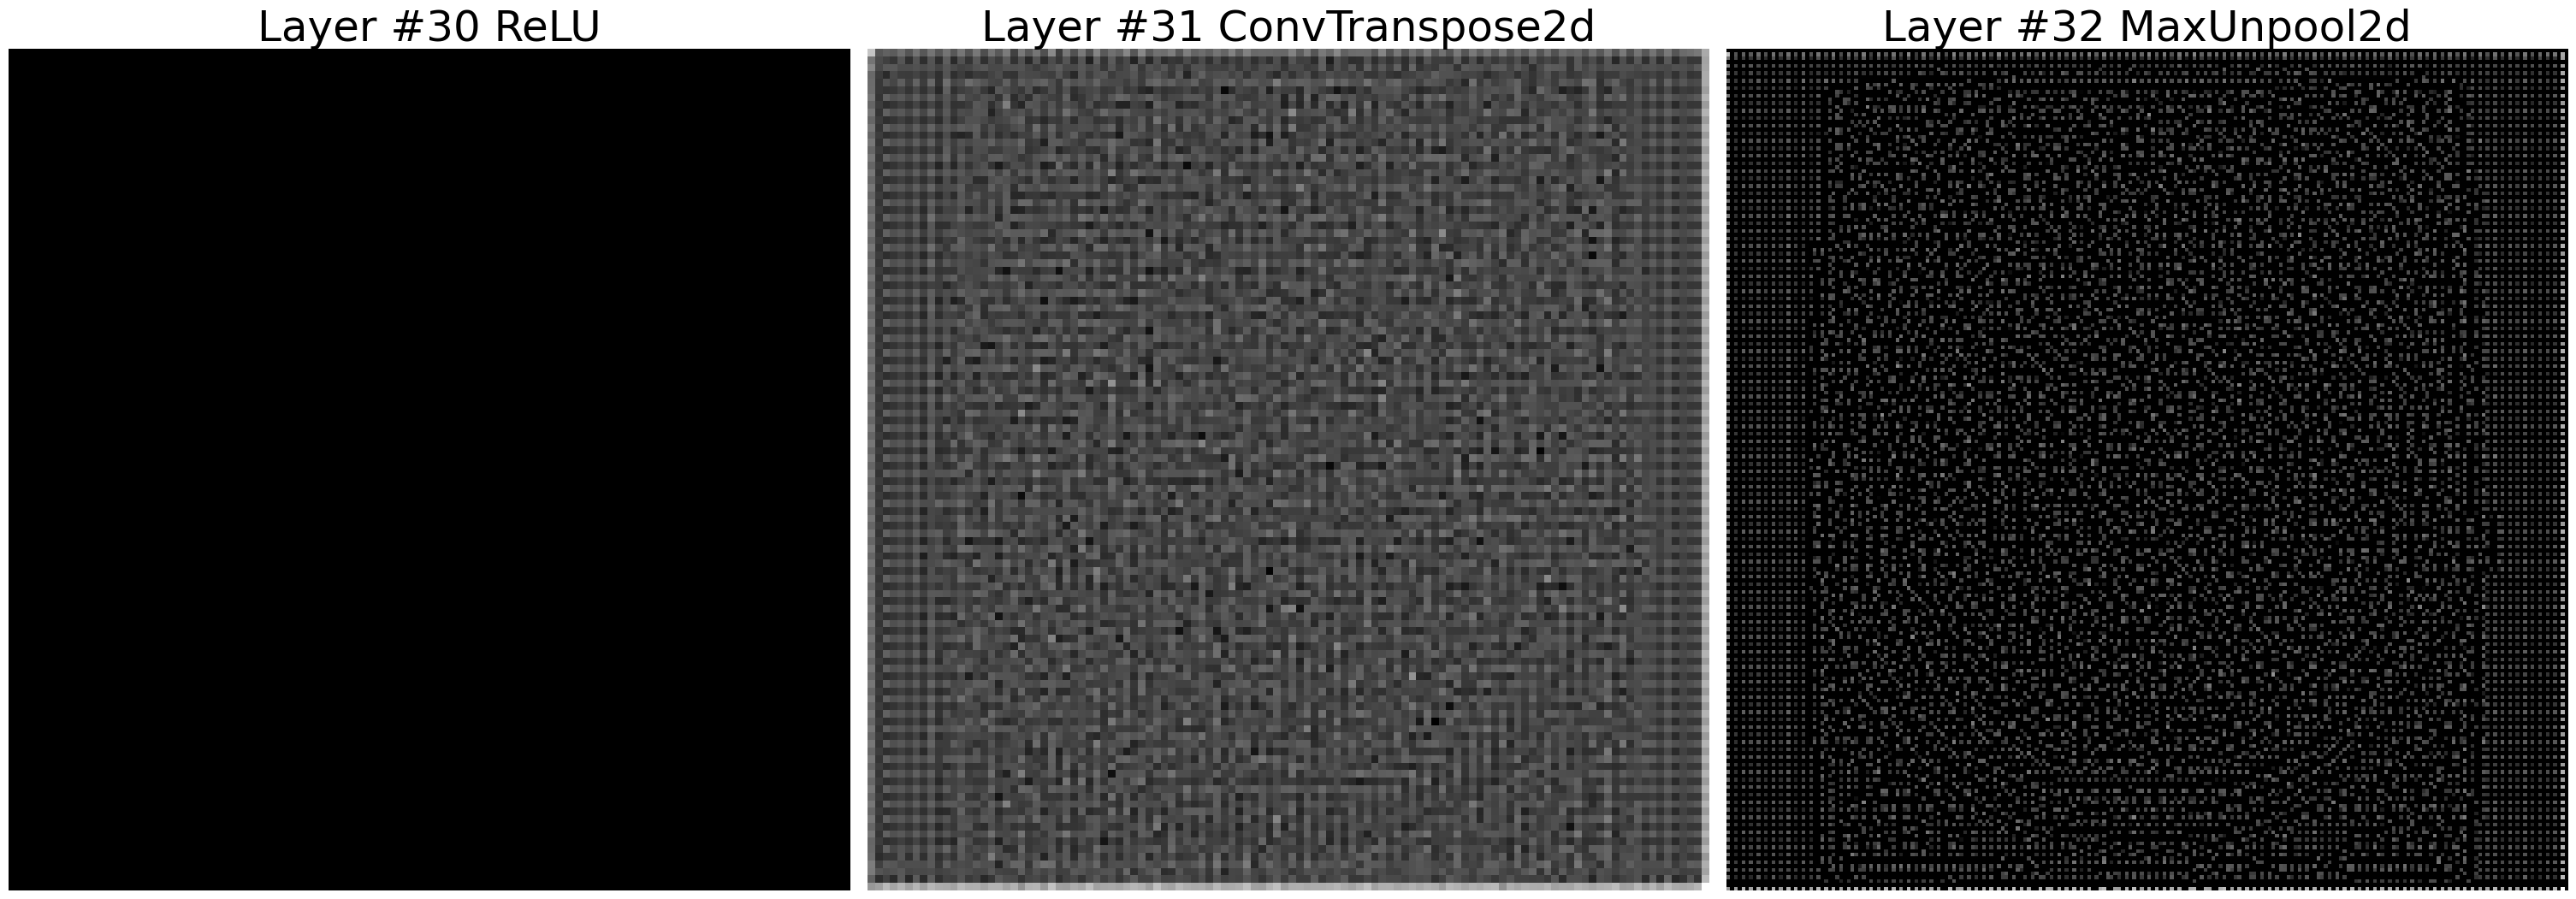

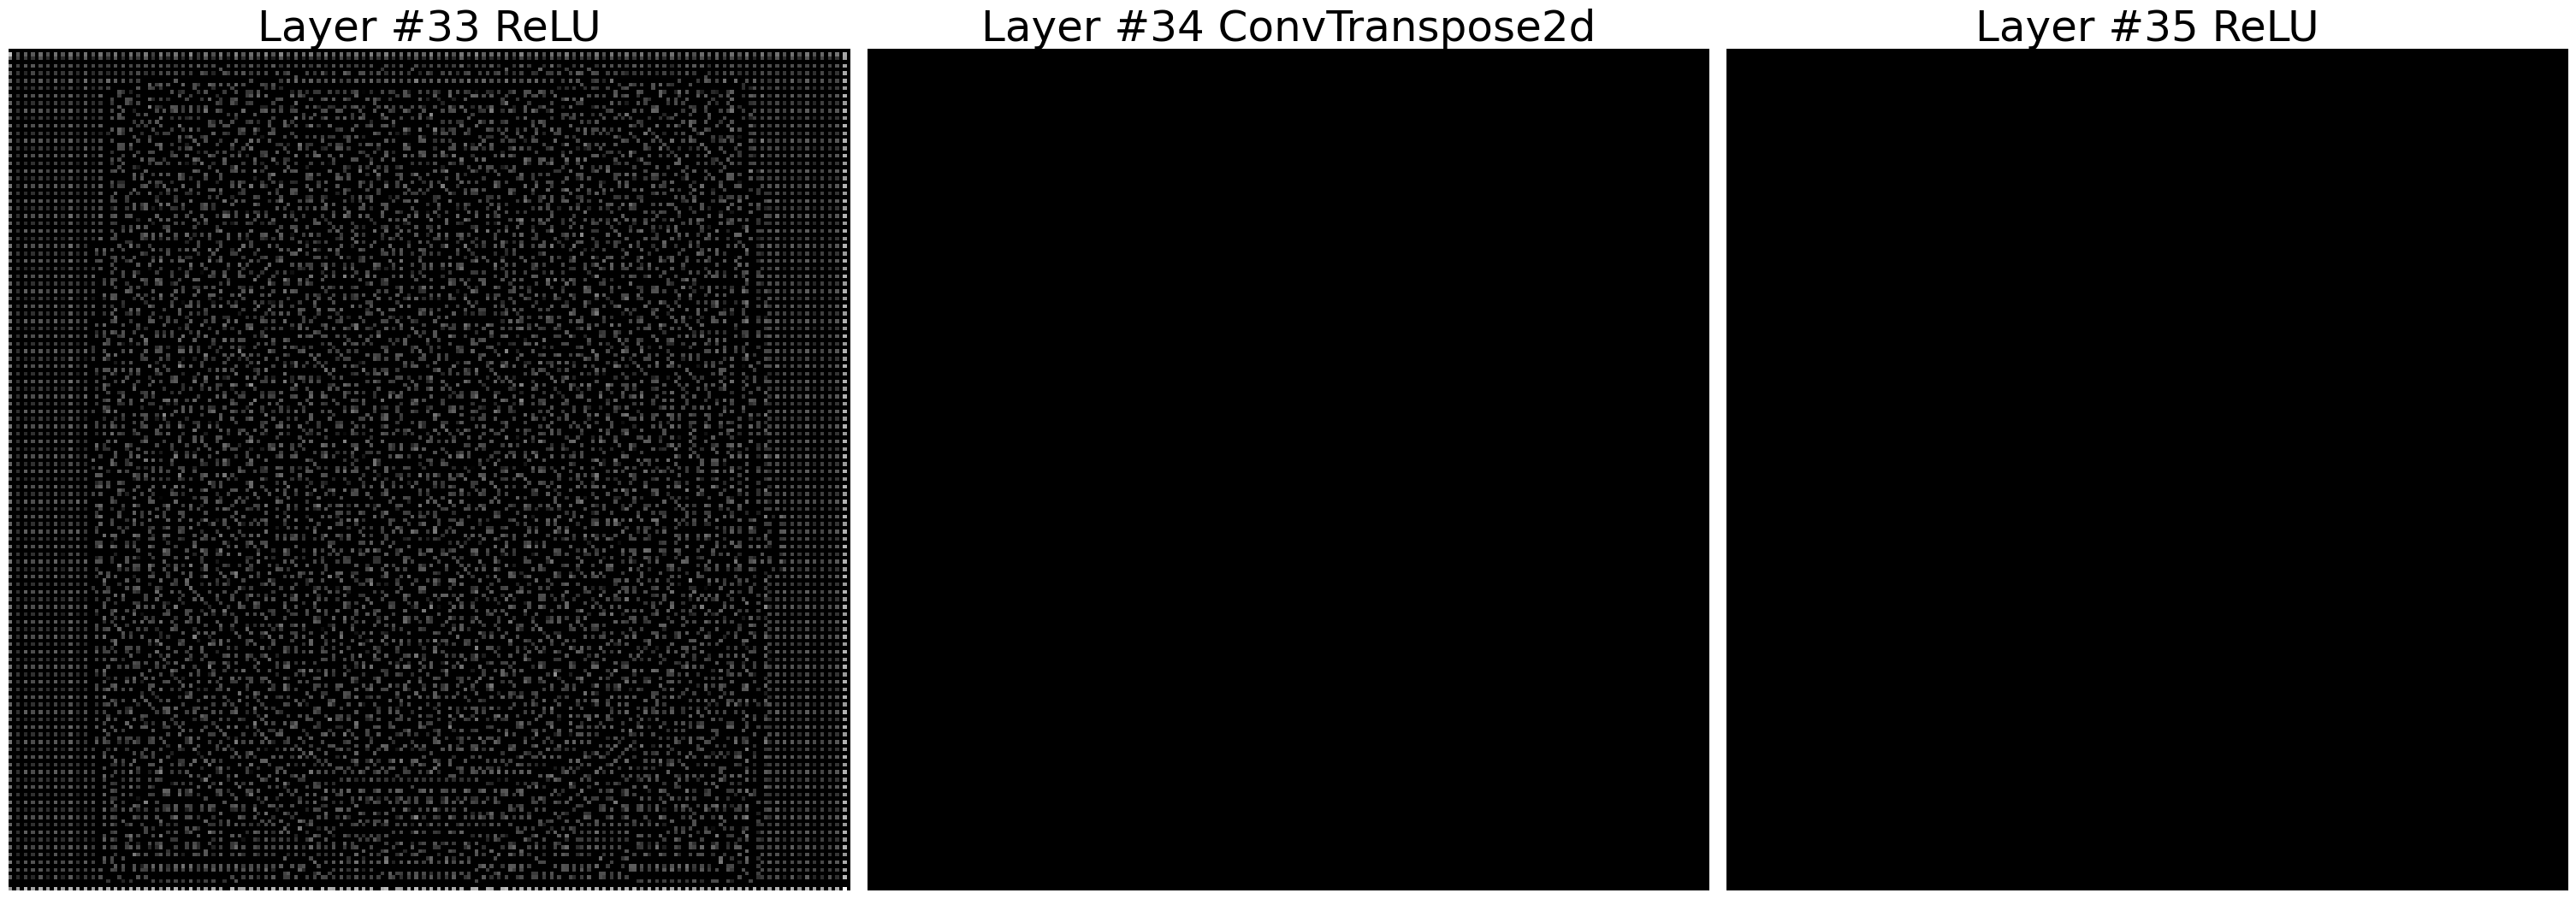

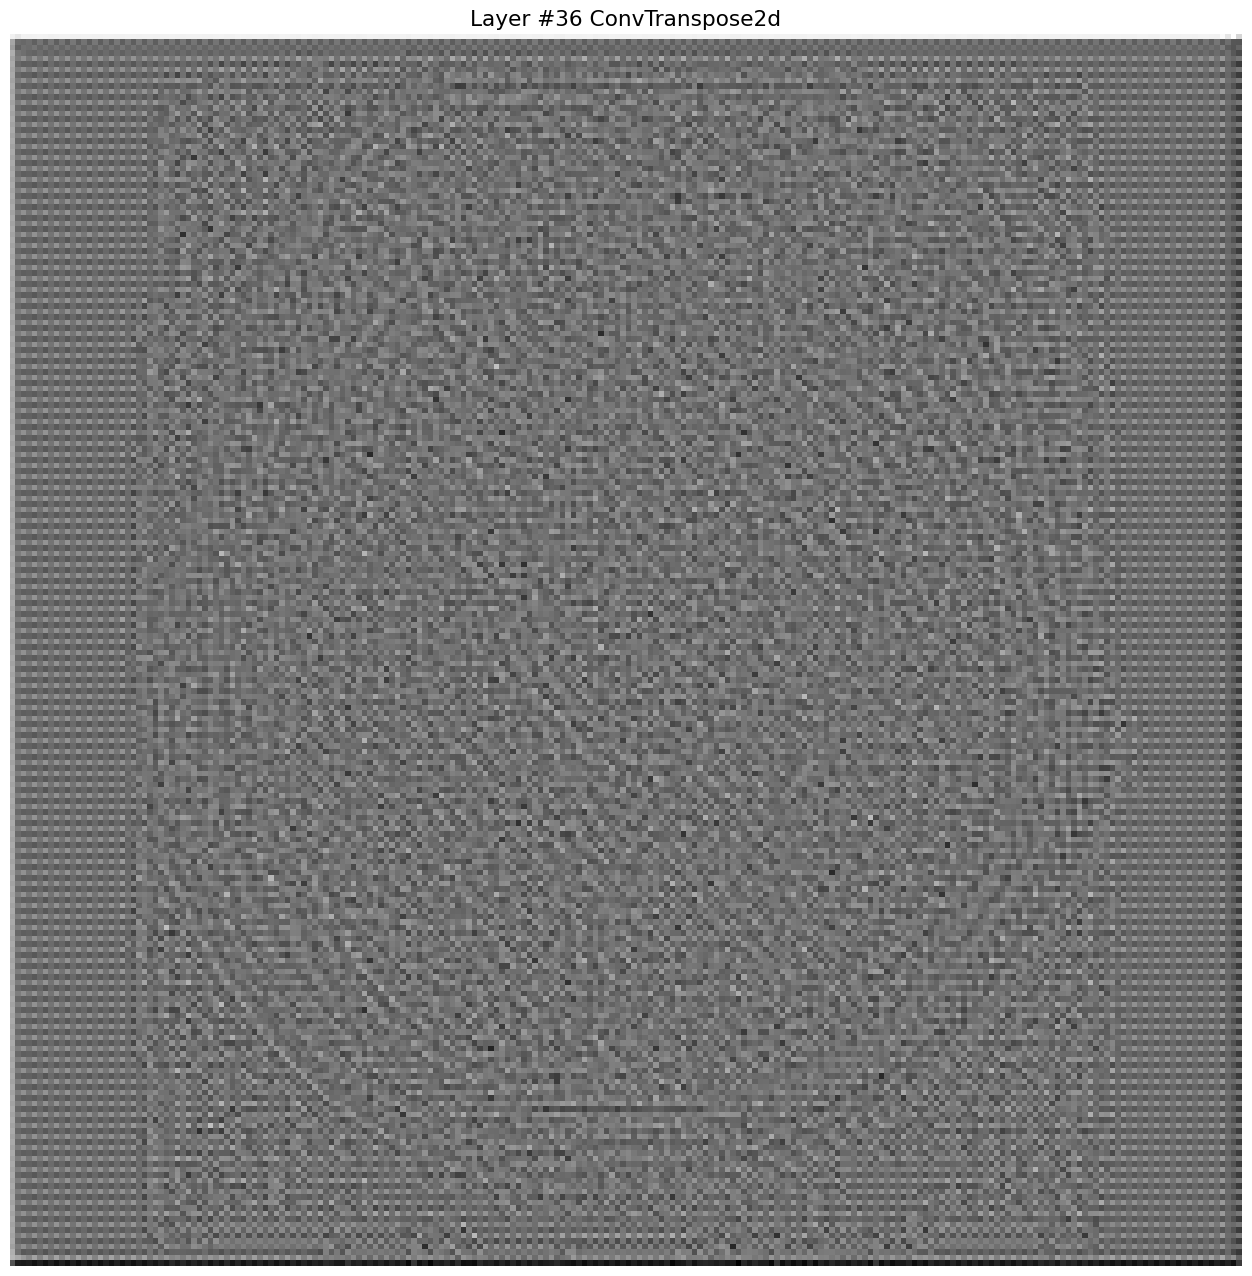

In [26]:
layer_names = [str(name).split('(', 1)[0] for _, name in deconv_net.deconvolution.named_children()]

pl.rcParams.update({'font.size': 30})

index = 0
for i in range(1, 37):
  if index < 36:
    f, axes = pl.subplots(1, 3, figsize = (30, 30), constrained_layout = True)

    for ax in axes:
      ax.imshow(deconv_net.batches[index].detach().numpy()[0, 2, :], cmap = 'gray')
      ax.axis('off')
      ax.set_title(f'Layer #{index} {layer_names[index]}')
      index += 1
    pl.show()

image = deconv_net.batches[36].detach().numpy()[0, 2, :]

pl.rcParams.update({'font.size': 13})
pl.rcParams['figure.figsize'] = [16, 16]
pl.imshow(image, cmap = 'gray')
pl.axis('off')
pl.title(f'Layer #36 {layer_names[36]}')
pl.show()

In [33]:
output = deconv_net.batches[2]

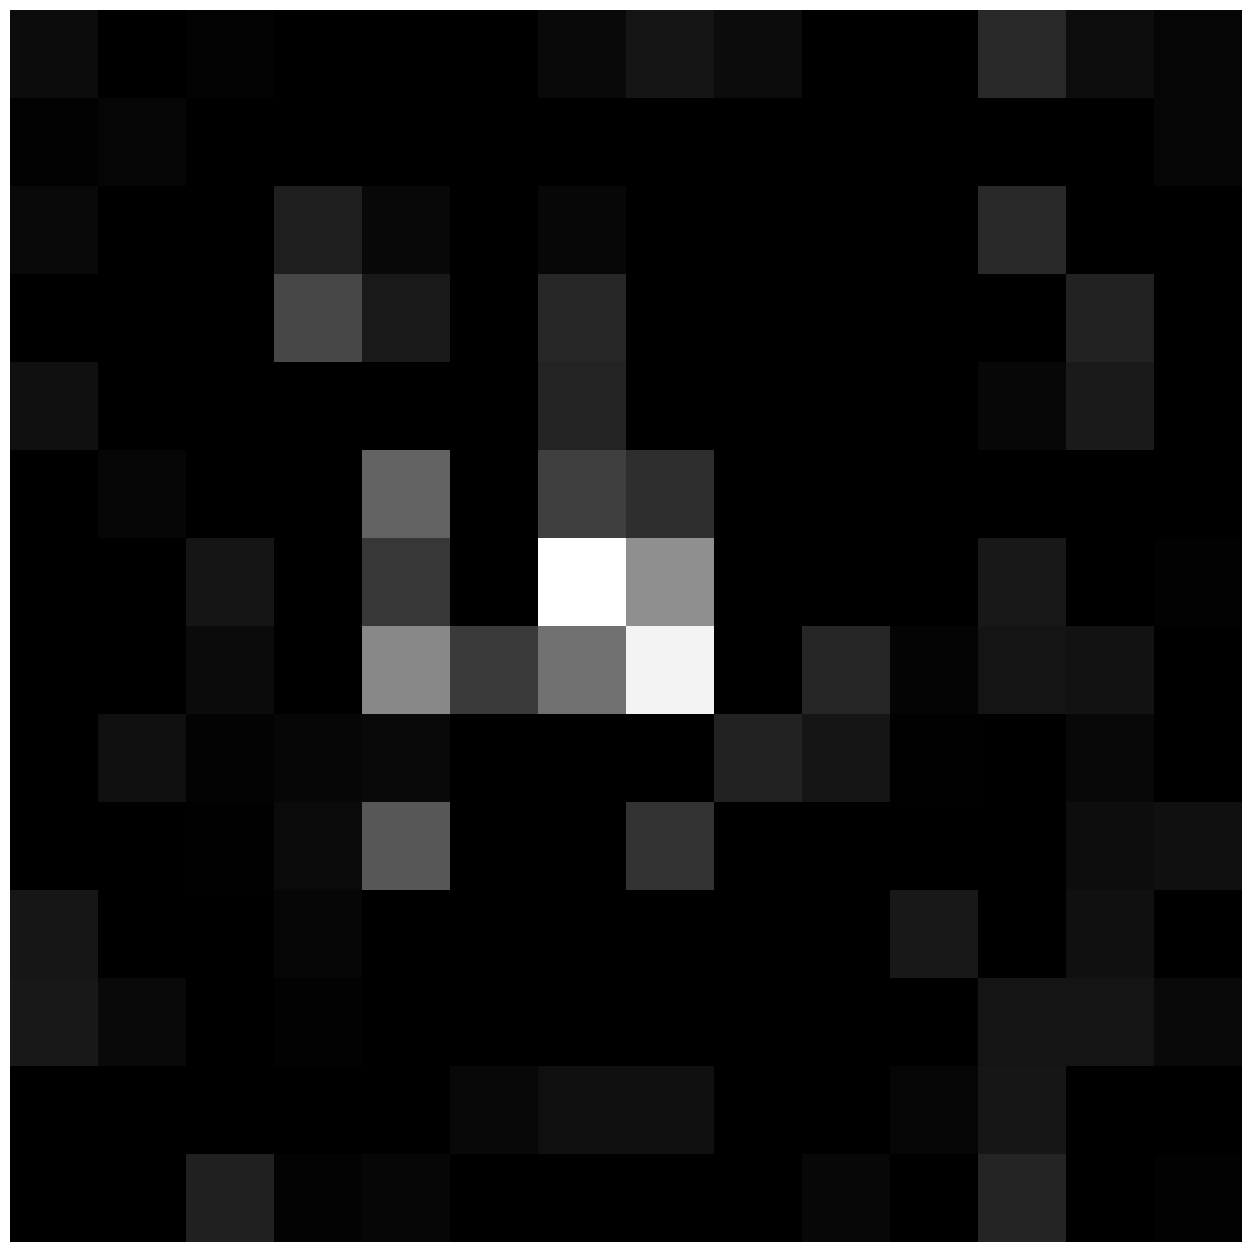

In [34]:
pl.imshow(output.detach().numpy()[0, 2, :], cmap = 'gray')
pl.axis('off')
pl.show()

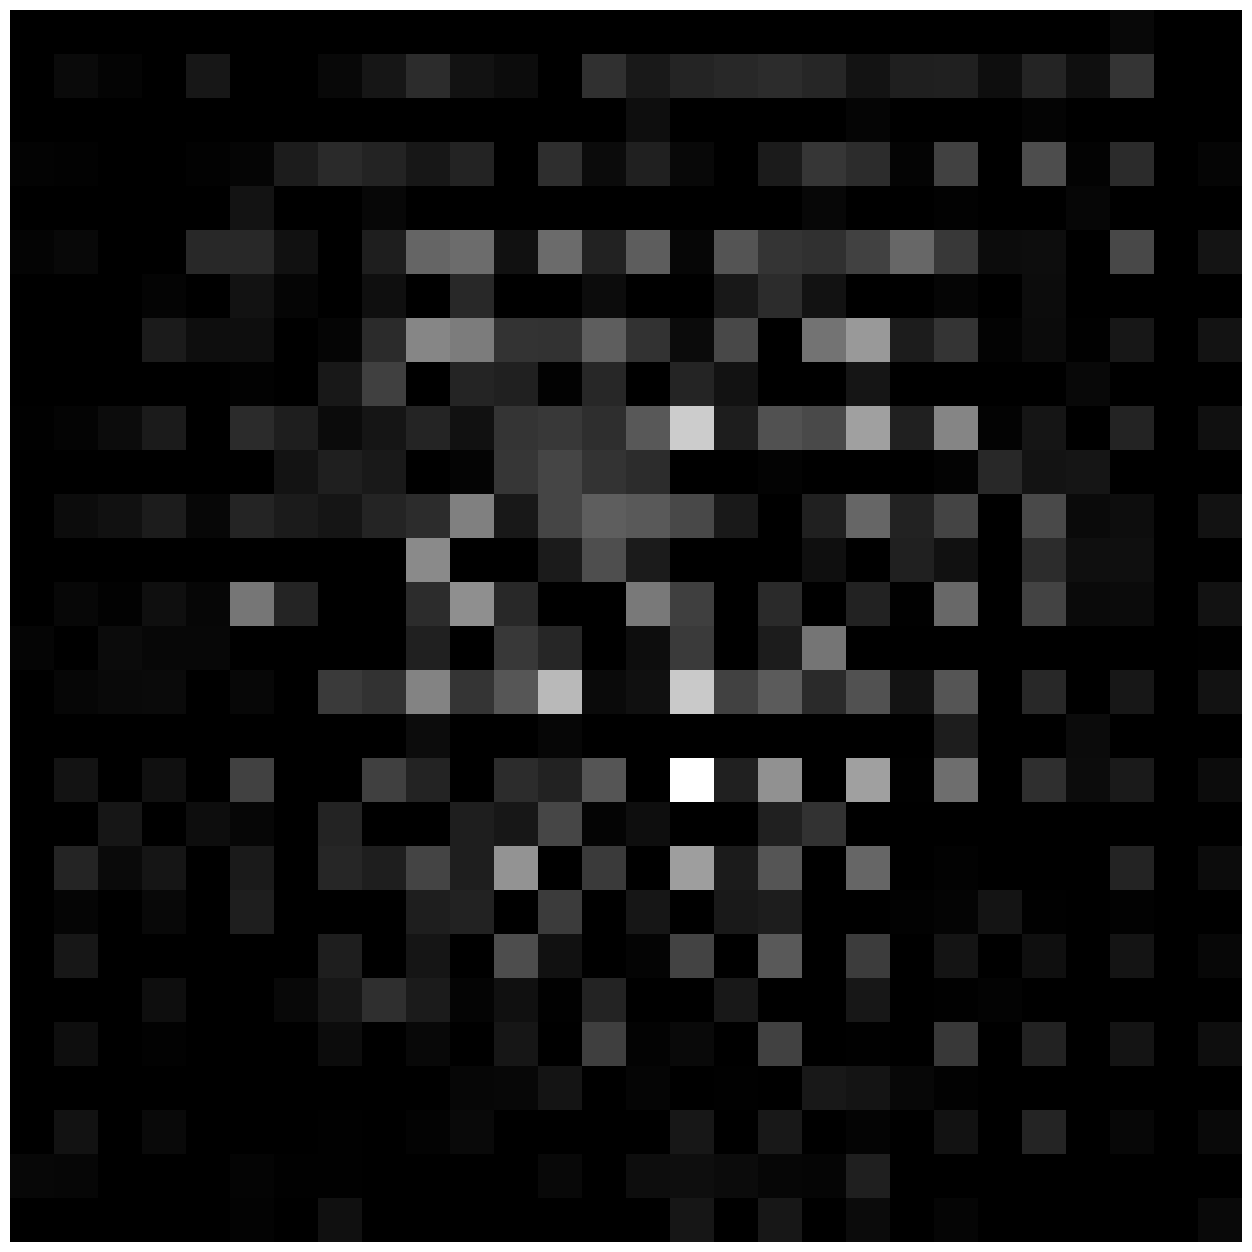

In [32]:
output = F.relu(output)

pl.imshow(output.detach().numpy()[0, 2, :], cmap = 'gray')
pl.axis('off')
pl.show()